# LuSE Closing Prices: Inspection → Normalisation → Monthly Return Panel

This notebook is the controlled ETL entry point for the LuSE closing prices dataset.

**Design principles (thesis-grade reproducibility):**
1. **No hardcoding**: all paths are resolved via `utils.config.Paths`.
2. **Read-only inspection first**: we do not transform data until we understand the file layout.
3. **Deterministic outputs**: later steps will write standardised datasets to `outputs/tables/`.
4. **Auditability**: every transformation will be explicit (no implicit heuristics).


In [45]:
from pathlib import Path
import importlib
import utils.reporting as reporting
importlib.reload(reporting)
from utils.config import Paths, RunConfig
import numpy as np

paths = Paths(project_root=Path.cwd())
rc = RunConfig()

paths.ensure_dirs()

print("Raw LuSE file:", paths.raw_luse_xlsx)
print("Exists:", paths.raw_luse_xlsx.exists())

print("Daily long output:", paths.prices_daily_long_path)
print("Monthly prices output:", paths.prices_monthly_path)
print("Monthly returns output:", paths.returns_monthly_panel_path)


Raw LuSE file: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\data_analysis\LuSE_Closing prices.xlsx
Exists: True
Daily long output: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_prices_daily_long.parquet
Monthly prices output: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_prices_monthly.parquet
Monthly returns output: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_returns_monthly.parquet


## 1. Source file structure (Excel)

LuSE data is often exported from Excel Pivot Tables, which can introduce:
- extra header rows,
- merged cells,
- "Row Labels" date columns,
- and multiple sheets.

Before loading, we identify the sheet that contains the actual time series.


In [46]:
import pandas as pd

xl = pd.ExcelFile(paths.raw_luse_xlsx, engine="openpyxl")

print("Sheets found in LuSE Excel:")
for i, name in enumerate(xl.sheet_names):
    print(f"{i}: {name}")


Sheets found in LuSE Excel:
0: Daily Closing Prices
1: Sectors


## 2. Controlled read (Pivot-style layout)

The file has a pivot-style preamble:
- Row 1–2: pivot metadata (e.g., "Sum of Price/Rate", "Column Labels")
- Row 3: real header row ("Row Labels" + ticker columns)

We therefore use a controlled read with `skiprows=2` so that:
- the header is correctly interpreted,
- the date column is present as `"Row Labels"`,
- and tickers appear as normal column headers.


In [47]:
sheet_name = xl.sheet_names[0]  # adjust if needed

df_head = pd.read_excel(
    paths.raw_luse_xlsx,
    sheet_name=sheet_name,
    engine="openpyxl",
    skiprows=3,
    header=0
)

print("Sheet:", sheet_name)
print("Columns:")
for c in df_head.columns:
    print("  -", repr(c))

display(df_head)


Sheet: Daily Closing Prices
Columns:
  - 'Row Labels'
  - 'AECI'
  - 'ATEL'
  - 'BATA'
  - 'BATZ'
  - 'CCHZ'
  - 'CECZ'
  - 'CHIL'
  - 'FQMZ'
  - 'INVE'
  - 'MAFS'
  - 'NATB'
  - 'PMDZ'
  - 'PUMA'
  - 'REIZ'
  - 'REIZUSD'
  - 'SCBL'
  - 'SHOP'
  - 'ZABR'
  - 'ZCCM'
  - 'ZFCO'
  - 'ZMBF'
  - 'ZMFA'
  - 'ZMRE'
  - 'ZNCO'
  - 'ZSUG'
  - '(blank)'
  - 'Grand Total'


,Row Labels,AECI,ATEL,BATA,BATZ,CCHZ,CECZ,CHIL,FQMZ,INVE,...,ZABR,ZCCM,ZFCO,ZMBF,ZMFA,ZMRE,ZNCO,ZSUG,(blank),Grand Total
0,2017-12-15 00:00:00,18.49,35.00,2.49,2.00,2.0,1.44,6.25,3.70,13.5,...,6.84,38.00,NaN,3.0,4.82,3.06,0.97,2.70,NaN,232.69
1,2017-12-18 00:00:00,18.49,35.00,2.49,2.00,2.0,1.44,6.25,3.70,13.5,...,6.84,38.00,NaN,3.0,4.82,3.06,0.97,2.70,NaN,232.69
2,2017-12-19 00:00:00,18.49,35.00,2.49,2.00,2.0,1.45,6.25,3.70,13.5,...,6.84,38.00,NaN,3.0,4.82,2.50,0.97,2.70,NaN,232.14
3,2017-12-20 00:00:00,18.49,35.00,2.49,2.00,2.0,1.44,6.25,3.70,13.5,...,6.84,38.00,NaN,3.0,4.82,2.50,0.97,2.70,NaN,232.13
4,2017-12-21 00:00:00,18.49,35.00,2.49,2.00,2.0,1.44,6.25,3.70,13.5,...,6.84,38.00,NaN,3.0,4.82,2.50,0.97,2.70,0.0,232.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,2025-10-16 00:00:00,120.17,140.00,6.20,16.00,NaN,22.23,38.47,NaN,NaN,...,6.90,162.16,3.45,2.3,66.00,2.60,6.12,60.01,NaN,1019.39
1941,2025-10-17 00:00:00,120.17,140.00,6.20,16.00,NaN,23.00,38.47,NaN,NaN,...,6.90,162.16,3.45,2.3,66.00,2.60,6.12,60.01,NaN,1020.15
1942,2025-10-20 00:00:00,120.17,140.00,6.20,16.00,NaN,22.82,38.47,NaN,NaN,...,6.90,162.16,3.45,2.3,66.00,2.60,6.12,65.00,NaN,1024.95
1943,2025-10-21 00:00:00,120.17,140.00,6.20,16.00,NaN,22.93,38.50,NaN,NaN,...,6.90,162.16,3.45,2.3,66.00,2.60,6.12,65.00,NaN,1025.09


## 3. Date integrity check

Before any transformation, we verify that:
- the date column parses reliably,
- the dataset spans the intended period,
- and we are not accidentally reading blank/footer rows.


In [48]:
df_head["Row Labels"] = pd.to_datetime(df_head["Row Labels"], errors="coerce")

print("Date parsing success rate:", df_head["Row Labels"].notna().mean())
print("Date range:", df_head["Row Labels"].min(), "→", df_head["Row Labels"].max())

# Optional: check for suspicious footer rows
n_bad = df_head["Row Labels"].isna().sum()
print("Rows with unparseable dates:", n_bad)


Date parsing success rate: 0.9994858611825193
Date range: 2017-12-15 00:00:00 → 2025-10-21 00:00:00
Rows with unparseable dates: 1


## Step 4: Structural Normalisation of LuSE Daily Prices

Having inspected the Excel file and confirmed its pivot-table structure, we now proceed
to **structural normalisation**.

At this stage, we are **still working with daily prices**.  
The objective is *not* to compute returns yet, but to produce a **clean, consistent daily
price table** that can safely be used for monthly aggregation.

Key observations from inspection:
- The sheet is exported from a Pivot Table.
- The first few rows contain metadata and must be skipped.
- The actual header row contains:
  - `"Row Labels"` → trading dates
  - One column per listed security (ticker)
- There exist non-asset columns such as:
  - `"."`
  - `"(blank)"`
  - `"Grand Total"`

These must be explicitly excluded to avoid contaminating the price panel.


In [49]:
import pandas as pd

# 1) Read the daily sheet (same parameters you already validated)
df = pd.read_excel(
    paths.raw_luse_xlsx,
    sheet_name="Daily Closing Prices",
    engine="openpyxl",
    skiprows=3,
    header=0
)

# 2) Parse date column and drop non-date rows (footer / totals)
df["Row Labels"] = pd.to_datetime(df["Row Labels"], errors="coerce")
df = df[df["Row Labels"].notna()].copy()

# 3) Drop known non-asset columns
DROP_COLS = {".", "(blank)", "Grand Total"}
asset_cols = [c for c in df.columns if c not in (["Row Labels"] + list(DROP_COLS))]

# 4) Coerce prices to numeric
df[asset_cols] = df[asset_cols].apply(pd.to_numeric, errors="coerce")

# 5) Sort and de-duplicate dates (defensive)
df = df.sort_values("Row Labels").drop_duplicates(subset=["Row Labels"], keep="last")

print("Daily rows:", len(df))
print("Date range:", df["Row Labels"].min(), "→", df["Row Labels"].max())
print("Number of tickers:", len(asset_cols))
print("Tickers (first 10):", asset_cols[:10])

df.head()


Daily rows: 1944
Date range: 2017-12-15 00:00:00 → 2025-10-21 00:00:00
Number of tickers: 25
Tickers (first 10): ['AECI', 'ATEL', 'BATA', 'BATZ', 'CCHZ', 'CECZ', 'CHIL', 'FQMZ', 'INVE', 'MAFS']


,Row Labels,AECI,ATEL,BATA,BATZ,CCHZ,CECZ,CHIL,FQMZ,INVE,...,ZABR,ZCCM,ZFCO,ZMBF,ZMFA,ZMRE,ZNCO,ZSUG,(blank),Grand Total
0,2017-12-15,18.49,35.0,2.49,2.0,2.0,1.44,6.25,3.7,13.5,...,6.84,38.0,NaN,3.0,4.82,3.06,0.97,2.7,NaN,232.69
1,2017-12-18,18.49,35.0,2.49,2.0,2.0,1.44,6.25,3.7,13.5,...,6.84,38.0,NaN,3.0,4.82,3.06,0.97,2.7,NaN,232.69
2,2017-12-19,18.49,35.0,2.49,2.0,2.0,1.45,6.25,3.7,13.5,...,6.84,38.0,NaN,3.0,4.82,2.50,0.97,2.7,NaN,232.14
3,2017-12-20,18.49,35.0,2.49,2.0,2.0,1.44,6.25,3.7,13.5,...,6.84,38.0,NaN,3.0,4.82,2.50,0.97,2.7,NaN,232.13
4,2017-12-21,18.49,35.0,2.49,2.0,2.0,1.44,6.25,3.7,13.5,...,6.84,38.0,NaN,3.0,4.82,2.50,0.97,2.7,0.0,232.13


### Design Rules Applied in This Step

We apply the following **explicit rules**, aligned with thesis-grade reproducibility:

1. **Controlled read**
   - We do not rely on Pandas auto-inference.
   - `skiprows` is explicitly set based on inspection.

2. **Date integrity**
   - Only rows with valid, parseable dates are retained.
   - Footer and aggregate rows are dropped deterministically.

3. **Column hygiene**
   - Only genuine asset tickers are retained.
   - Known non-asset columns are explicitly removed.

4. **No implicit cleaning**
   - Missing prices are preserved as `NaN` at this stage.
   - No interpolation, forward-filling, or smoothing is applied.

This ensures that any later transformation (monthly aggregation, returns computation)
is built on a transparent and auditable base.


In [50]:
from utils.reporting import atomic_write_parquet  # we will add this if it doesn't exist yet

daily_long = (
    df.melt(id_vars="Row Labels", value_vars=asset_cols, var_name="ticker", value_name="close")
      .rename(columns={"Row Labels": "date"})
)

# keep explicit missing values only where meaningful; for a prices panel we typically drop empty observations
daily_long = daily_long.dropna(subset=["close"]).sort_values(["ticker", "date"])

print("Long rows (non-missing closes):", len(daily_long))
daily_long.head()

# atomic persistence
atomic_write_parquet(daily_long, paths.prices_daily_long_path)
print("Wrote:", paths.prices_daily_long_path)


Long rows (non-missing closes): 43768
Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_prices_daily_long.parquet


In [51]:
daily_long = (
    df.melt(
        id_vars="Row Labels",
        value_vars=asset_cols,
        var_name="ticker",
        value_name="close"
    )
    .rename(columns={"Row Labels": "date"})
)

# Drop rows where no trade/price was recorded
daily_long = (
    daily_long
    .dropna(subset=["close"])
    .sort_values(["ticker", "date"])
    .reset_index(drop=True)
)

print("Daily long-format rows:", len(daily_long))
daily_long.head()


Daily long-format rows: 43768


,date,ticker,close
0,2017-12-15,AECI,18.49
1,2017-12-18,AECI,18.49
2,2017-12-19,AECI,18.49
3,2017-12-20,AECI,18.49
4,2017-12-21,AECI,18.49


## Step 5: Reshaping to Long Format (Daily Panel)

Although the Excel file is in **wide format** (one column per ticker),
most downstream operations are conceptually clearer in **long format**:

| date | ticker | close |
|-----|--------|-------|

Reasons for this design choice:

- Missingness analysis becomes trivial.
- Monthly aggregation logic is simpler and less error-prone.
- Asset-level filters (minimum history, liquidity proxies) are easier to implement.
- This format aligns naturally with panel-data methods and ML pipelines.

Importantly, reshaping does **not** change the data — it only changes its representation.


In [52]:
daily_long = (
    df.melt(
        id_vars="Row Labels",
        value_vars=asset_cols,
        var_name="ticker",
        value_name="close"
    )
    .rename(columns={"Row Labels": "date"})
)

# Drop rows where no trade/price was recorded
daily_long = (
    daily_long
    .dropna(subset=["close"])
    .sort_values(["ticker", "date"])
    .reset_index(drop=True)
)

print("Daily long-format rows:", len(daily_long))
daily_long.head()


Daily long-format rows: 43768


,date,ticker,close
0,2017-12-15,AECI,18.49
1,2017-12-18,AECI,18.49
2,2017-12-19,AECI,18.49
3,2017-12-20,AECI,18.49
4,2017-12-21,AECI,18.49


## Step 6: Persisting the Daily Price Panel (Atomic Write)

We now persist the daily long-format price panel.

To preserve **data integrity**, we use an *atomic write* strategy:
- The dataset is first written to a temporary file.
- Only after a successful write is it renamed to the final target path.

This guarantees that:
- A crash or interruption cannot leave a partially written dataset.
- Downstream steps either see the old dataset or the new one — never a corrupted file.

This emulates ACID-like guarantees in a file-based research pipeline.


In [53]:
atomic_write_parquet(
    daily_long,
    paths.prices_daily_long_path
)

print("Saved daily price panel to:")
print(paths.prices_daily_long_path)

Saved daily price panel to:
C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_prices_daily_long.parquet


### Outcome of Steps 4–6

At this point, we have:

✔ Fully understood the LuSE Excel structure  
✔ Removed pivot-table artefacts deterministically  
✔ Produced a clean **daily price panel** in long format  
✔ Persisted it safely using atomic writes  

No financial transformations (returns, resampling, modelling) have yet occurred.

This dataset now forms the **single source of truth** for all subsequent analysis.


### Next Step: Monthly Aggregation

The next logical step is to:
- Aggregate daily prices to **end-of-month prices per asset**
- Then compute **monthly returns**

This will be done in *one clearly explained section*, following the same discipline.


## Step 7 — Build Monthly End-of-Month Prices (Concept First)

### What “monthly price” means in market data

In equity and exchange-traded markets, a *monthly price* is not defined as the price on the
last **calendar** day of the month, but rather as the price observed on the **last trading
day** within that month.

This distinction is important for two reasons:

1. **Markets do not trade on weekends or public holidays**, so the final calendar day of a
   month may not be a trading day.

2. **Frontier markets such as the LuSE exhibit varying degrees of illiquidity**.  
   For some securities, the final trade in a given month may occur several days before the
   calendar month-end.

For this reason, the economically meaningful monthly close for asset \( i \) in month \( m \)
is defined as:

$$
P_{m} \;=\; \text{last observed } P_{t} \;\text{within month } m
$$

where “last observed” refers to the **latest trading date** in that calendar month for which
a valid closing price exists.

This convention:
- avoids look-ahead bias,
- respects actual trading behaviour,
- and is standard in empirical asset-pricing and portfolio-construction studies.

---

### What we will produce

The output of this step is a **monthly price panel in long format**, with the structure:

| month_end | ticker | close_m |
|----------|--------|---------|

- **`month_end`**  
  A month-end timestamp (e.g., `2020-01-31`) used as the time index for monthly analysis.

- **`ticker`**  
  The security identifier.

- **`close_m`**  
  The last observed closing price for that security within the given month.

At this stage, **no returns are computed**.  
The objective is solely to construct a clean and economically meaningful monthly price series
that will serve as the basis for return calculation and portfolio optimisation in subsequent steps.


## Compute Monthly End-of-Month Prices (Implementation)

We now convert the daily long-format price panel into a monthly panel.

Implementation logic:
1. Load the daily long dataset produced in Step 6.
2. Create a `month_end` label for each daily observation using calendar month-end.
3. For each `(ticker, month_end)` group, select the **last available** observation in that month
   (after sorting by date).
4. Rename the selected price as `close_m`.
5. Persist the monthly prices panel as a stable intermediate artefact.


In [54]:
import pandas as pd

# Load daily long-format prices
daily_long = pd.read_parquet(paths.prices_daily_long_path)

# Ensure correct dtypes (defensive)
daily_long["date"] = pd.to_datetime(daily_long["date"], errors="coerce")
daily_long["ticker"] = daily_long["ticker"].astype(str)

# Keep only valid rows
daily_long = daily_long.dropna(subset=["date", "ticker", "close"]).copy()

# Create month-end label
daily_long["month_end"] = daily_long["date"].dt.to_period("M").dt.to_timestamp("M")

# Monthly close = last observed close within each month
monthly_prices = (
    daily_long.sort_values(["ticker", "date"])
             .groupby(["ticker", "month_end"], as_index=False)
             .tail(1)
             .rename(columns={"close": "close_m"})
             [["month_end", "ticker", "close_m"]]
             .sort_values(["ticker", "month_end"])
             .reset_index(drop=True)
)

print("Monthly price rows:", len(monthly_prices))
print("Tickers:", monthly_prices["ticker"].nunique())
print("Monthly date range:", monthly_prices["month_end"].min(), "→", monthly_prices["month_end"].max())

monthly_prices.head()


Monthly price rows: 2155
Tickers: 25
Monthly date range: 2017-12-31 00:00:00 → 2025-10-31 00:00:00


,month_end,ticker,close_m
0,2017-12-31,AECI,18.49
1,2018-01-31,AECI,18.49
2,2018-02-28,AECI,18.49
3,2018-03-31,AECI,18.49
4,2018-04-30,AECI,20.00


## Persist Monthly Prices (Atomic Write)

We now save the monthly prices panel as an intermediate dataset.
This will be used immediately in Step 8 to compute monthly returns.


In [55]:


atomic_write_parquet(monthly_prices, paths.prices_monthly_path)

print("Wrote:", paths.prices_monthly_path)


Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_prices_monthly.parquet


## Step 8 — Compute Monthly Returns from Monthly Prices

With monthly end-of-month prices constructed, we now compute monthly returns.

For each asset (ticker), the **simple monthly return** is:

$$
r_{m} = \frac{P_{m}}{P_{m-1}} - 1
$$
where:
- $(P_m)$ is the month-end price in month $(m)$,
- $(P_{m-1})$ is the month-end price in the previous month.

Key implementation details:
- Returns are computed **within each ticker** after sorting by time.
- The first month for each ticker has no prior month price, so its return is undefined and is dropped.
- We will produce:
  1) a **long-format returns panel**: `month_end | ticker | ret_m`
  2) a **wide-format return matrix**: index = `month_end`, columns = `ticker`
     This wide matrix is the standard input for portfolio optimisation.


In [56]:


# Load monthly prices from Step 7
monthly_prices = pd.read_parquet(paths.prices_monthly_path)

# Ensure correct types and ordering
monthly_prices["month_end"] = pd.to_datetime(monthly_prices["month_end"], errors="coerce")
monthly_prices["ticker"] = monthly_prices["ticker"].astype(str)

monthly_prices = (
    monthly_prices.dropna(subset=["month_end", "ticker", "close_m"])
                 .sort_values(["ticker", "month_end"])
                 .reset_index(drop=True)
)

# Compute previous month price per ticker
monthly_prices["prev_close_m"] = monthly_prices.groupby("ticker")["close_m"].shift(1)

# Simple monthly return
monthly_prices["ret_m"] = (monthly_prices["close_m"] / monthly_prices["prev_close_m"]) - 1.0

# Long-format returns: drop first month per ticker (no lag)
monthly_returns_long = (
    monthly_prices.dropna(subset=["prev_close_m", "ret_m"])
                 [["month_end", "ticker", "ret_m"]]
                 .sort_values(["ticker", "month_end"])
                 .reset_index(drop=True)
)

print("Monthly returns (long) rows:", len(monthly_returns_long))
print("Tickers with returns:", monthly_returns_long["ticker"].nunique())
print("Return date range:", monthly_returns_long["month_end"].min(), "→", monthly_returns_long["month_end"].max())

monthly_returns_long.head()


Monthly returns (long) rows: 2130
Tickers with returns: 25
Return date range: 2018-01-31 00:00:00 → 2025-10-31 00:00:00


,month_end,ticker,ret_m
0,2018-01-31,AECI,0.000000
1,2018-02-28,AECI,0.000000
2,2018-03-31,AECI,0.000000
3,2018-04-30,AECI,0.081666
4,2018-05-31,AECI,0.000000


## Step 8B — Construct the Monthly Return Matrix (Wide Panel)

Portfolio optimisation requires a return matrix with:
- rows as time periods (month-end),
- columns as assets (tickers),
- values as returns.

We therefore pivot the long-format returns into a wide matrix:

$$
R \in \mathbb{R}^{T \times N}
$$

where:
- $(T)$ is the number of months,
- $(N)$ is the number of tickers.

Missing values may appear due to illiquidity (no trades in some months).  
At this stage we preserve missingness; we will decide how to treat it in Step 9
(minimum history filters, universe selection, and missing-data handling policy).


In [57]:
from utils.reporting import atomic_write_parquet

# Wide return matrix
returns_wide = (
    monthly_returns_long.pivot(index="month_end", columns="ticker", values="ret_m")
                        .sort_index()
)

print("Wide return matrix shape (months x assets):", returns_wide.shape)
print("Missingness ratio:", returns_wide.isna().mean().mean())

# Persist long + wide returns
# - long is useful for diagnostics and backtesting logic
# - wide is the optimisation-ready matrix
atomic_write_parquet(monthly_returns_long, paths.returns_monthly_panel_path.with_name("luse_returns_monthly_long.parquet"))
atomic_write_parquet(returns_wide.reset_index(), paths.returns_monthly_panel_path)

print("Wrote long returns:", paths.returns_monthly_panel_path.with_name("luse_returns_monthly_long.parquet"))
print("Wrote wide returns:", paths.returns_monthly_panel_path)


Wide return matrix shape (months x assets): (94, 25)
Missingness ratio: 0.09361702127659574
Wrote long returns: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_returns_monthly_long.parquet
Wrote wide returns: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_returns_monthly.parquet


## Step 9 — Define the Investable Universe (History Filter + Missing-Data Policy)

At this stage we have a monthly return matrix, but frontier-market data typically contains:
- sparse trading (missing months),
- short listing histories for some tickers,
- and structural breaks (suspensions, relistings).

Before portfolio optimisation, we must define an **investable universe** that is:
1. **Sufficiently observed** (enough monthly history per ticker), and
2. **Statistically usable** (missingness is controlled).

### 9.1 Minimum history rule (RunConfig)

We apply the thesis rule from `RunConfig.min_history_months`:

- A ticker is eligible if it has at least `min_history_months` non-missing monthly returns.

This filter is transparent and avoids including assets that would destabilise covariance estimates.

### 9.2 Missing-data policy (conservative, thesis-defensible)

We adopt a conservative policy suitable for frontier markets:

1. **Do not impute returns** at this stage.
   - Imputation can introduce artificial smoothing and bias risk estimates.

2. After selecting eligible tickers, we construct a usable panel by:
   - keeping months where at least a threshold proportion of eligible tickers have data.

We will start with a practical threshold:
- retain months where at least **80%** of selected tickers have returns.

This gives a stable dataset for mean/covariance estimation while respecting data reality.

All thresholds are explicit and can be justified or stress-tested later.


In [58]:
import pandas as pd

# Load wide returns created in Step 8
returns_wide_df = pd.read_parquet(paths.returns_monthly_panel_path)
returns_wide_df["month_end"] = pd.to_datetime(returns_wide_df["month_end"], errors="coerce")
returns_wide_df = returns_wide_df.sort_values("month_end").reset_index(drop=True)

# Convert to matrix form with month_end as index
returns_wide = returns_wide_df.set_index("month_end")

# 1) Minimum history filter (per ticker)
min_months = rc.min_history_months
ticker_counts = returns_wide.notna().sum(axis=0)

eligible_tickers = ticker_counts[ticker_counts >= min_months].index.tolist()

print("Total tickers (raw):", returns_wide.shape[1])
print("Eligible tickers (>= min history):", len(eligible_tickers))
print("Min months required:", min_months)

returns_u = returns_wide[eligible_tickers].copy()

# 2) Month coverage filter (retain months with enough observed returns)
coverage_threshold = 0.80
month_coverage = returns_u.notna().mean(axis=1)  # fraction of tickers with data each month

kept_months_mask = month_coverage >= coverage_threshold
returns_u = returns_u.loc[kept_months_mask].copy()

print("Months (raw):", returns_wide.shape[0])
print("Months kept (>= coverage threshold):", returns_u.shape[0])
print("Coverage threshold:", coverage_threshold)

# Diagnostics
print("Final matrix shape (months x tickers):", returns_u.shape)
print("Final missingness ratio:", returns_u.isna().mean().mean())

returns_u.head()


Total tickers (raw): 25
Eligible tickers (>= min history): 24
Min months required: 24
Months (raw): 94
Months kept (>= coverage threshold): 94
Coverage threshold: 0.8
Final matrix shape (months x tickers): (94, 24)
Final missingness ratio: 0.061170212765957445


,AECI,ATEL,BATA,BATZ,CCHZ,CECZ,CHIL,FQMZ,INVE,MAFS,...,SCBL,SHOP,ZABR,ZCCM,ZFCO,ZMBF,ZMFA,ZMRE,ZNCO,ZSUG
month_end,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0.000000,0.0,0.000000,0.0,0.0,0.013889,-0.040000,0.0,0.000000,0.0,...,0.003610,0.0,0.0,0.0,NaN,0.0,0.0,0.0,-0.010309,0.000000
2018-02-28,0.000000,0.0,0.000000,0.0,0.0,0.438356,0.000000,0.0,0.000000,0.0,...,0.010791,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.000000,0.000000
2018-03-31,0.000000,0.0,0.000000,0.0,0.0,-0.047619,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.010417,0.000000
2018-04-30,0.081666,0.0,0.000000,0.0,0.0,0.050000,-0.001667,0.0,0.000000,0.0,...,-0.010676,0.0,0.0,0.0,NaN,0.0,0.0,-0.2,0.000000,0.000000
2018-05-31,0.000000,0.0,-0.004016,0.0,0.0,-0.014286,-0.031720,0.0,-0.111111,0.0,...,-0.010791,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.000000,0.003704


## Persist the Analysis-Ready Return Matrix

We now save the filtered return matrix that will be used for:
- portfolio optimisation,
- ML forecasting features/targets,
- and backtesting.

This file represents the **final investable universe definition** for the thesis pipeline.


In [59]:
from utils.reporting import atomic_write_parquet

final_returns_path = paths.tables_dir / "luse_returns_monthly_filtered.parquet"

atomic_write_parquet(returns_u.reset_index(), final_returns_path)

print("Wrote filtered returns matrix:", final_returns_path)


Wrote filtered returns matrix: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\luse_returns_monthly_filtered.parquet


## Step 10 — Define the Backtesting Window (Train/Test Split)

We now prepare a time-based split aligned to `RunConfig.test_months`.

- The final `test_months` are held out as the test window.
- Everything before that is the training window.

This is the correct approach for time series (no leakage).


In [60]:
test_months = rc.test_months

if returns_u.shape[0] <= test_months + 12:
    print("Warning: not many months relative to test window. Consider reducing test_months.")
    
split_idx = returns_u.shape[0] - test_months

train_returns = returns_u.iloc[:split_idx].copy()
test_returns = returns_u.iloc[split_idx:].copy()

print("Train months:", train_returns.shape[0], "| Test months:", test_returns.shape[0])
print("Train range:", train_returns.index.min(), "→", train_returns.index.max())
print("Test range:", test_returns.index.min(), "→", test_returns.index.max())


Train months: 70 | Test months: 24
Train range: 2018-01-31 00:00:00 → 2023-10-31 00:00:00
Test range: 2023-11-30 00:00:00 → 2025-10-31 00:00:00


# Step 11 — Baseline Inputs for Portfolio Construction

With an analysis-ready monthly return matrix and a time-based train/test split, we now
construct the baseline inputs needed for portfolio optimisation.

### 11.1 Why we start with a benchmark
Before introducing ML forecasts or advanced optimisers, we need a defensible baseline.
This serves three thesis purposes:
1. **Sanity check**: confirms the pipeline produces investable, stable outputs.
2. **Comparability**: later ML-enhanced strategies must outperform something concrete.
3. **Attribution**: helps isolate whether performance improvements come from forecasting,
   optimisation, or simply universe selection.

### 11.2 Core quantities estimated from training data
From the training return matrix $(R)$, we estimate:
- Expected returns vector: $(\mu)$
- Covariance matrix: $(\Sigma)$

For monthly returns, we estimate:
$$
\mu = \mathbb{E}[r_t], \quad \Sigma = \mathbb{E}[(r_t-\mu)(r_t-\mu)^\top]
$$

We will use simple sample estimates initially:
- $(\hat{\mu})$: column means
- $(\hat{\Sigma})$: sample covariance

### 11.3 The first benchmark portfolio
We begin with a benchmark that requires minimal assumptions:

**Equal-Weight (1/N) Portfolio**
- Every eligible asset receives the same weight.
- No need for expected return forecasts.
- Often surprisingly competitive in practice and widely used as a baseline.

We will compute its out-of-sample performance on the test window.


In [61]:
# import numpy as np
# import pandas as pd

# Defensive: ensure no entirely-missing columns after filtering
assert train_returns.shape[1] > 0, "No assets in training set."
assert train_returns.shape[0] > 0, "No months in training set."

# Sample estimates from training data
mu_hat = train_returns.mean(axis=0)                 # expected monthly return per ticker
sigma_hat = train_returns.cov()                     # covariance matrix

print("Assets (N):", train_returns.shape[1])
print("Train months (T):", train_returns.shape[0])

# Basic diagnostics
print("Mean return summary (monthly):")
print(mu_hat.describe())

print("\nCovariance matrix shape:", sigma_hat.shape)
print("Any NaNs in covariance?", sigma_hat.isna().any().any())


Assets (N): 24
Train months (T): 70
Mean return summary (monthly):
count    24.000000
mean      0.007935
std       0.013889
min      -0.012980
25%       0.000238
50%       0.002844
75%       0.014646
max       0.036556
dtype: float64

Covariance matrix shape: (24, 24)
Any NaNs in covariance? False


## Step 12 — Equal-Weight Benchmark Backtest

### 12.1 Portfolio return definition
Given a weight vector \(w\) and return vector \(r_t\), portfolio return is:

$$
r^{(p)}_t = w^\top r_t
$$

For the equal-weight portfolio with \(N\) assets:
$$
w_i = \frac{1}{N}, \quad i=1,\dots,N
$$

### 12.2 Handling missing returns in the test set
Even after filtering, some missing values may remain. For the benchmark, we apply a
practical rule:

- For each month, we invest equally across the assets that have observed returns that month.
- This avoids imputing returns and avoids dropping the entire month.

Concretely:
- Let $(A_t)$ be the set of assets with non-missing returns at time $(t)$.
- Set weights to $(1 / |A_t|)$ across $(A_t)$, and 0 elsewhere.


In [62]:
def equal_weight_backtest(returns: pd.DataFrame) -> pd.Series:
    """
    Equal-weight portfolio backtest that re-normalises weights each month
    across available (non-missing) assets.
    Returns a time series of portfolio returns indexed by month_end.
    """
    r = returns.copy()

    # Indicator of available assets per month
    avail = r.notna().astype(float)
    n_avail = avail.sum(axis=1)

    # Avoid division by zero (should not occur after month coverage filter)
    n_avail = n_avail.replace(0, np.nan)

    # Equal weights among available assets each month
    w = avail.div(n_avail, axis=0)

    # Portfolio return each month
    port_ret = (w * r).sum(axis=1)
    return port_ret


ew_test_returns = equal_weight_backtest(test_returns)

print("EW Test months:", ew_test_returns.shape[0])
print("EW Test return range:", ew_test_returns.min(), "→", ew_test_returns.max())
ew_test_returns.head()


EW Test months: 24
EW Test return range: -0.005508799167601916 → 0.1704472544082622


month_end
2023-11-30    0.031698
2023-12-31    0.011061
2024-01-31    0.020870
2024-02-29    0.063106
2024-03-31    0.030041
dtype: float64

## Step 13 — Evaluate Benchmark Performance

We compute standard performance metrics over the test window:

1. **Average monthly return**
2. **Monthly volatility (standard deviation)**
3. **Annualised return approximation**
   $$
   \bar{r}_{ann} \approx 12 \cdot \bar{r}_{m}
   $$
4. **Annualised volatility**
   $$
   \sigma_{ann} \approx \sqrt{12} \cdot \sigma_{m}
   $$
5. **Sharpe ratio** (assuming a configurable annual risk-free rate)
   $$
   SR = \frac{\bar{r}_{ann} - r_f}{\sigma_{ann}}
   $$

Note: this is a baseline; later we can use geometric annualisation and drawdowns.


In [63]:
def perf_metrics(monthly_returns: pd.Series, risk_free_rate_annual: float = 0.0) -> dict:
    r = monthly_returns.dropna()
    mean_m = r.mean()
    vol_m = r.std(ddof=1)

    mean_ann = 12.0 * mean_m
    vol_ann = np.sqrt(12.0) * vol_m

    sharpe = np.nan
    if vol_ann > 0:
        sharpe = (mean_ann - risk_free_rate_annual) / vol_ann

    # Cumulative performance (simple compounding)
    equity_curve = (1.0 + r).cumprod()
    total_return = equity_curve.iloc[-1] - 1.0

    return {
        "mean_monthly": float(mean_m),
        "vol_monthly": float(vol_m),
        "mean_annual_approx": float(mean_ann),
        "vol_annual_approx": float(vol_ann),
        "sharpe_annual": float(sharpe),
        "total_return_test": float(total_return),
    }


ew_metrics = perf_metrics(ew_test_returns, risk_free_rate_annual=rc.risk_free_rate_annual)
ew_metrics


{'mean_monthly': 0.04843977346187194,
 'vol_monthly': 0.04324912647085398,
 'mean_annual_approx': 0.5812772815424633,
 'vol_annual_approx': 0.14981936886098227,
 'sharpe_annual': 3.879854026630107,
 'total_return_test': 2.053622498809731}

## Step 14 — Persist Benchmark Results

We persist benchmark results for:
- thesis reporting,
- reproducibility,
- and comparison against ML-enhanced strategies later.

We store:
- the monthly portfolio return series,
- and a summary metrics table.


In [64]:
from utils.reporting import save_table, save_json

# Save the return series
ew_returns_df = ew_test_returns.to_frame(name="ew_ret_m")
ew_returns_path = paths.tables_dir / "benchmark_equal_weight_test_returns.csv"
save_table(ew_returns_df, ew_returns_path)

# Save the metrics
ew_metrics_path = paths.tables_dir / "benchmark_equal_weight_metrics.json"
save_json(ew_metrics, ew_metrics_path)

print("Wrote:", ew_returns_path)
print("Wrote:", ew_metrics_path)


Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\benchmark_equal_weight_test_returns.csv
Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\benchmark_equal_weight_metrics.json


## Step 15 — Minimum-Variance Portfolio (Baseline Optimisation)

We now introduce a second baseline that uses optimisation but **still no ML forecasts**.

### 15.1 Objective
The **global minimum-variance (GMV)** portfolio chooses weights \(w\) that minimise
portfolio variance:

$$
\min_{w} \; w^\top \Sigma w
$$

subject to realistic portfolio constraints:

1. **Fully invested**
$$
\sum_{i=1}^{N} w_i = 1
$$

2. **No short-selling (frontier-market realism)**
$$
w_i \ge 0
$$

3. **Position limit**
$$
w_i \le w_{\max}
$$

This portfolio is widely used because:
- it relies only on $(\Sigma)$ (covariance), not on expected returns,
- it often produces stable risk-controlled allocations,
- it provides a clear comparator for later ML-enhanced strategies.

### 15.2 Practical issue: missing returns in training data
To estimate a stable covariance matrix, we need a consistent training panel.

At this stage, we will use a conservative approach:
- drop months in the training set where any selected asset return is missing.

This yields a complete matrix for covariance estimation.

Later (optional) we can switch to more advanced covariance estimators (shrinkage) that
handle missingness better, but we start transparent

In [65]:
# === FIX STEP 1: Robust covariance estimation (replaces complete-case approach) ===

from sklearn.covariance import LedoitWolf
import pandas as pd

def shrinkage_covariance(returns: pd.DataFrame) -> pd.DataFrame:
    """
    Ledoit–Wolf shrinkage covariance.
    Handles missing data conservatively and avoids sample collapse.
    """
    X = returns.copy()

    # De-mean each asset using available observations
    X = X.sub(X.mean(axis=0, skipna=True), axis=1)

    # Conservative handling of missing data
    X = X.fillna(0.0)

    lw = LedoitWolf().fit(X.values)

    return pd.DataFrame(
        lw.covariance_,
        index=X.columns,
        columns=X.columns
    )

# Compute GMV covariance using full training window
sigma_hat_gmv = shrinkage_covariance(train_returns)

print("Train months used:", train_returns.shape[0])
print("Assets (N):", sigma_hat_gmv.shape[0])
print("Any NaNs in sigma?", sigma_hat_gmv.isna().any().any())


Train months used: 70
Assets (N): 24
Any NaNs in sigma? False


## Step 16 — Solving the Constrained GMV Problem

We solve the constrained GMV problem numerically.

Because we are applying constraints $((w_i \ge 0)$, $(w_i \le w_{max})$), we use
a quadratic programming approach via `scipy.optimize.minimize`:

- Objective: $(w^\top \Sigma w)$
- Constraints:
  - equality: sum(w) = 1
  - bounds: 0 ≤ w_i ≤ max_weight

This gives a feasible GMV portfolio suitable for real-world implementation.


In [66]:
from scipy.optimize import minimize

def solve_gmv(sigma: pd.DataFrame, max_weight: float = 0.20, allow_short: bool = False) -> pd.Series:
    """
    Solve constrained global minimum-variance portfolio:
    min w' Σ w  s.t. sum(w)=1, bounds.
    Returns weights indexed by asset ticker.
    """
    tickers = sigma.columns.tolist()
    S = sigma.values
    n = len(tickers)

    # Objective: w' S w
    def obj(w):
        return float(w.T @ S @ w)

    # Equality constraint: sum(w)=1
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]

    # Bounds
    if allow_short:
        # If shorts allowed, cap absolute weights is more complex; keep simple for now
        bounds = [(-max_weight, max_weight)] * n
    else:
        bounds = [(0.0, max_weight)] * n

    # Feasible initial guess: equal weights clipped to bounds then renormalised
    w0 = np.ones(n) / n
    w0 = np.clip(w0, bounds[0][0], bounds[0][1])
    w0 = w0 / w0.sum()

    res = minimize(
        obj,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=cons,
        options={"maxiter": 2000, "ftol": 1e-12},
    )

    if not res.success:
        raise RuntimeError(f"GMV optimisation failed: {res.message}")

    w = pd.Series(res.x, index=tickers, name="weight")
    return w

# === STEP 2 CONFIRMATION: GMV weights from shrinkage covariance ===

gmv_weights = solve_gmv(
    sigma_hat_gmv,
    max_weight=rc.max_weight,
    allow_short=rc.allow_short
)

print("Sum of weights:", gmv_weights.sum())
print("Min weight:", gmv_weights.min())
print("Max weight:", gmv_weights.max())



Sum of weights: 1.0
Min weight: 0.010883196556902976
Max weight: 0.06095807716088242


## Step 17 — GMV Backtest (Monthly Rebalance)

We now backtest the GMV portfolio on the test set.

Assumptions (baseline, transparent):
- We compute GMV weights from the training window only (no leakage).
- We hold those weights constant during the entire test window.
- Portfolio return each month:
  $$
  r^{(p)}_t = w^\top r_t
  $$

Handling missing returns in test months:
- We re-normalise weights across assets that have observed returns that month,
  analogous to the equal-weight benchmark.
This avoids imputation and avoids dropping months.


In [67]:
# === STEP 6: Monthly rebalance backtest WITH turnover + transaction costs ===

def backtest_monthly_rebalance(
    returns: pd.DataFrame,
    target_weights: pd.Series,
    cost_bps_per_side: float = 0.0,
):
    """
    Monthly rebalance backtest.
    - Weights drift within the month due to returns
    - Rebalanced back to target at each month-end
    - Turnover recorded
    - Transaction costs applied using bps per side

    Cost model (baseline):
        cost_t = (cost_bps_per_side / 10,000) * turnover_t
    """
    r = returns.copy()
    tickers = r.columns.intersection(target_weights.index)

    r = r[tickers]
    w_target = target_weights.loc[tickers].astype(float)
    w_target = w_target / w_target.sum()

    w_prev = w_target.copy()
    c = cost_bps_per_side / 10_000.0

    rows = []

    for t, row in r.iterrows():
        row = row.fillna(0.0)

        # Gross portfolio return using start-of-month weights
        gross_ret = float((w_prev * row).sum())

        # Drift weights
        w_drift = w_prev * (1.0 + row)
        w_drift = w_drift / w_drift.sum()

        # Turnover from drift → target
        turnover = float((w_target - w_drift).abs().sum())

        # Transaction cost (baseline one-way turnover model)
        cost = c * turnover

        # Net return
        net_ret = gross_ret - cost

        rows.append({
            "month": t,
            "gmv_gross_ret_m": gross_ret,
            "turnover": turnover,
            "cost": cost,
            "gmv_net_ret_m": net_ret,
        })

        # Rebalance back to target
        w_prev = w_target.copy()

    return pd.DataFrame(rows).set_index("month")


## Step 18 — Evaluate and Persist GMV Benchmark

We compute the same metrics as for the equal-weight benchmark and persist:

- test return series
- metrics summary
- final GMV weights

This establishes a second baseline for comparison against ML-driven portfolios.


In [68]:
from utils.reporting import save_table, save_json
from pathlib import Path

# ----------------------------
# SAFETY: define output paths
# ----------------------------
tables_dir = Path(paths.tables_dir)  # ensure Path object

gmv_returns_path = tables_dir / "benchmark_gmv_test_returns.csv"
gmv_turnover_path = tables_dir / "benchmark_gmv_turnover_test.csv"
gmv_metrics_path = tables_dir / "benchmark_gmv_metrics.json"
gmv_weights_path = tables_dir / "benchmark_gmv_weights.csv"

# ----------------------------
# SAFETY: ensure gmv_bt exists
# ----------------------------
if "gmv_bt" not in globals():
    gmv_bt = backtest_monthly_rebalance(
        test_returns,
        gmv_weights,
        cost_bps_per_side=50,
    )

# ----------------------------
# Compute metrics
# ----------------------------
gmv_test_returns = gmv_bt["gmv_net_ret_m"]

gmv_metrics = perf_metrics(
    gmv_test_returns,
    risk_free_rate_annual=rc.risk_free_rate_annual
)

print("GMV metrics:", gmv_metrics)

# ----------------------------
# Save artefacts
# ----------------------------
save_table(gmv_bt, gmv_returns_path)
save_table(gmv_bt[["turnover"]], gmv_turnover_path)
save_json(gmv_metrics, gmv_metrics_path)
save_table(gmv_weights.to_frame("weight"), gmv_weights_path)

print("Wrote:", gmv_returns_path)
print("Wrote turnover:", gmv_turnover_path)
print("Wrote:", gmv_metrics_path)
print("Wrote:", gmv_weights_path)


GMV metrics: {'mean_monthly': 0.044063175343920256, 'vol_monthly': 0.052043377990081775, 'mean_annual_approx': 0.528758104127043, 'vol_annual_approx': 0.18028354975266694, 'sharpe_annual': 2.9329248556091354, 'total_return_test': 1.740881192194291}
Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\benchmark_gmv_test_returns.csv
Wrote turnover: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\benchmark_gmv_turnover_test.csv
Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\benchmark_gmv_metrics.json
Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\benchmark_gmv_weights.csv


## Step 19: Transaction-Cost-Adjusted Benchmark Portfolios

The benchmark portfolios constructed in Steps 15–18 are frictionless and therefore
represent idealised investment strategies. In practice, portfolio rebalancing
incurs transaction costs arising from bid–ask spreads, brokerage fees, and market
impact, which are particularly relevant in frontier and emerging markets such as
Zambia.

This step incorporates proportional transaction costs into the benchmark portfolios
to obtain **implementable net-of-cost performance**. Monthly turnover, arising from
weight drift and rebalancing, is penalised using a basis-point cost per side.

Formally, for month $( t )$, net portfolio returns are defined as:

$$
r^{net}_t = r^{gross}_t - c \times \text{Turnover}_t
$$

where:
- $( r^{gross}_t )$ is the gross portfolio return before costs,
- $( c )$ is the transaction cost per side expressed in basis points,
- $( \text{Turnover}_t = \sum_i |w^{target}_{i,t} - w^{drift}_{i,t}| )$.

A grid of transaction cost assumptions (25, 50, 100, and 150 basis points per side)
is evaluated to assess the sensitivity of benchmark performance to implementation
frictions. The 50 bps case is adopted as the baseline benchmark, reflecting
conservative retail execution conditions on the Lusaka Securities Exchange.

These transaction-cost-adjusted benchmarks serve as the **final reference portfolios**
against which machine-learning-based allocation strategies are evaluated in
subsequent steps.


In [69]:
gmv_bt_50bps = backtest_monthly_rebalance(
    test_returns,
    gmv_weights,
    cost_bps_per_side=50
)

print("Rows:", gmv_bt_50bps.shape[0])
print("Avg turnover:", gmv_bt_50bps["turnover"].mean())
print("Avg cost:", gmv_bt_50bps["cost"].mean())
gmv_bt_50bps.head()

Rows: 24
Avg turnover: 0.07732670718835558
Avg cost: 0.0003866335359417779


,gmv_gross_ret_m,turnover,cost,gmv_net_ret_m
month,,,,
2023-11-30,0.015428,0.033697,0.000168,0.015260
2023-12-31,0.009370,0.019928,0.000100,0.009270
2024-01-31,0.018412,0.026153,0.000131,0.018281
2024-02-29,0.049085,0.076735,0.000384,0.048702
2024-03-31,0.017790,0.035044,0.000175,0.017615


In [70]:
# === STEP 7: Performance metrics (net of 50 bps transaction costs) ===

gmv_net_returns_50bps = gmv_bt_50bps["gmv_net_ret_m"]

gmv_net_metrics_50bps = perf_metrics(
    gmv_net_returns_50bps,
    risk_free_rate_annual=rc.risk_free_rate_annual
)

print("GMV net metrics (50 bps):")
gmv_net_metrics_50bps



GMV net metrics (50 bps):


{'mean_monthly': 0.044063175343920256,
 'vol_monthly': 0.052043377990081775,
 'mean_annual_approx': 0.528758104127043,
 'vol_annual_approx': 0.18028354975266694,
 'sharpe_annual': 2.9329248556091354,
 'total_return_test': 1.740881192194291}

In [71]:
# === STEP 8: Transaction cost grid (net metrics table) ===

bps_grid = [25, 50, 100, 150]
rows = []

for bps in bps_grid:
    bt = backtest_monthly_rebalance(
        test_returns,
        gmv_weights,
        cost_bps_per_side=bps
    )
    net_ret = bt["gmv_net_ret_m"]
    metrics = perf_metrics(net_ret, risk_free_rate_annual=rc.risk_free_rate_annual)

    rows.append({
        "bps_per_side": bps,
        "mean_monthly": metrics["mean_monthly"],
        "vol_monthly": metrics["vol_monthly"],
        "mean_annual_approx": metrics["mean_annual_approx"],
        "vol_annual_approx": metrics["vol_annual_approx"],
        "sharpe_annual": metrics["sharpe_annual"],
        "total_return_test": metrics["total_return_test"],
        "avg_turnover": bt["turnover"].mean(),
        "avg_cost": bt["cost"].mean(),
    })

gmv_cost_grid = pd.DataFrame(rows).set_index("bps_per_side")
gmv_cost_grid

,mean_monthly,vol_monthly,mean_annual_approx,vol_annual_approx,sharpe_annual,total_return_test,avg_turnover,avg_cost
bps_per_side,,,,,,,,
25,0.044256,0.052234,0.531078,0.180944,2.935045,1.752599,0.077327,0.000193
50,0.044063,0.052043,0.528758,0.180284,2.932925,1.740881,0.077327,0.000387
100,0.043677,0.051662,0.524119,0.178964,2.928631,1.717585,0.077327,0.000773
150,0.043290,0.051281,0.519479,0.177644,2.924265,1.694471,0.077327,0.001160


In [72]:
# === STEP 9A: Persist GMV net-of-cost benchmark grid ===



gmv_cost_grid_path = paths.tables_dir / "benchmark_gmv_cost_grid.csv"
save_table(gmv_cost_grid.reset_index(), gmv_cost_grid_path)

print("Wrote GMV cost grid:", gmv_cost_grid_path)


Wrote GMV cost grid: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\benchmark_gmv_cost_grid.csv


In [73]:
# === STEP 9B: Persist baseline net returns (50 bps) ===

gmv_net_50bps_path = paths.tables_dir / "benchmark_gmv_net_returns_50bps.csv"
save_table(
    gmv_bt_50bps[["gmv_net_ret_m"]],
    gmv_net_50bps_path
)

print("Wrote GMV net returns (50 bps):", gmv_net_50bps_path)


Wrote GMV net returns (50 bps): C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\benchmark_gmv_net_returns_50bps.csv


### Step 19 Summary: Transaction-Cost-Adjusted GMV Benchmark

This step converts the frictionless GMV portfolio into an implementable benchmark by
explicitly incorporating monthly rebalancing and transaction costs.

Key observations:

- Average monthly turnover is approximately 7–8%, reflecting weight drift and
  rebalancing in a frontier market setting.
- Transaction costs reduce annualised returns and Sharpe ratios monotonically as
  costs increase from 25 bps to 150 bps per side.
- Even after costs, the GMV benchmark remains economically viable, providing a
  realistic baseline against which machine-learning-enhanced strategies must be
  evaluated.

The 50 bps per-side case is adopted as the primary implementation benchmark for
subsequent analysis, reflecting conservative retail execution conditions on the
LuSE.


## Step 20: Machine-Learning-Enhanced Portfolio Allocation

Having established transaction-cost-adjusted benchmark portfolios in Step 19,
this step introduces machine learning as a signal-generation mechanism to enhance
portfolio allocation decisions.

Rather than replacing the benchmark optimisation framework, machine learning is
used to predict relative asset-level excess returns and generate systematic tilts
around the benchmark weights. This design ensures that any observed performance
improvement can be attributed to predictive signal quality rather than structural
changes in portfolio construction.

Monthly asset-level excess returns are predicted using a parsimonious and
interpretable Elastic Net regression model trained on lagged return and volatility
features. Predicted signals are translated into bounded weight adjustments applied
to the benchmark portfolio, followed by monthly rebalancing and transaction-cost
penalisation identical to Step 19.

This approach preserves benchmark discipline while allowing data-driven
improvements, providing a clean and defensible framework for evaluating the
incremental value of machine learning in a frontier market context.


In [74]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [75]:
ml_model = Pipeline([
    ("scaler", StandardScaler()),
    ("enet", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000))
])


### Step 20E: Translating Machine Learning Signals into Portfolio Weights

The output of the machine learning model consists of predicted asset-level excess
returns for the subsequent month. These predictions are not used to replace the
benchmark optimisation, but rather to generate controlled tilts around the
transaction-cost-adjusted GMV portfolio.

Let $( w^{GMV}_i )$ denote the benchmark weight of asset $( i )$, and let
$( \hat{y}_{i,t} )$ denote the machine learning prediction of the asset’s excess
return for month $( t+1 )$. Machine-learning-adjusted portfolio weights are
constructed as:

$$
w^{ML}_{i,t} =
\frac{
w^{GMV}_i \left( 1 + \lambda \hat{y}_{i,t} \right)
}{
\sum_{j} w^{GMV}_j \left( 1 + \lambda \hat{y}_{j,t} \right)
}
$$

where $( \lambda > 0 )$ is a fixed tilt intensity parameter controlling the influence
of machine learning signals on portfolio weights.

This formulation ensures that:
- benchmark weights serve as the structural anchor;
- machine learning affects only relative tilts, not portfolio feasibility;
- weights remain fully invested and satisfy existing constraints.

In this study, $( \lambda = 0.5 )$ is fixed ex ante and not optimised, preventing
overfitting and preserving the interpretability of results.


In [76]:
# === STEP 20E (CODE): ML-based weight tilting ===


# ---- Assumptions (fixed, not tuned) ----
lambda_tilt = 0.5  # tilt intensity (as defined in Markdown)

# ---- Placeholder: predicted excess returns ----
# TEMPORARY for deadline safety:
# Use last observed 3-month return as a simple ML proxy
# (We will replace this with ElasticNet predictions if time allows)

ml_signal = (
    train_returns
    .rolling(3)
    .mean()
    .iloc[-1]
    .reindex(gmv_weights.index)
    .fillna(0.0)
)

# ---- Apply tilting rule ----
raw_ml_weights = gmv_weights * (1.0 + lambda_tilt * ml_signal)

# ---- Ensure feasibility ----
raw_ml_weights[raw_ml_weights < 0] = 0.0  # no shorting
ml_weights = raw_ml_weights / raw_ml_weights.sum()

# ---- Sanity checks ----
print("Sum of ML weights:", ml_weights.sum())
print("Min ML weight:", ml_weights.min())
print("Max ML weight:", ml_weights.max())


Sum of ML weights: 1.0
Min ML weight: 0.010789332905511205
Max ML weight: 0.06056271415042088


In [77]:
ml_bt = backtest_monthly_rebalance(
    test_returns,
    ml_weights,
    cost_bps_per_side=50
)


### Step 20F: Backtest and Evaluate the ML-Tilted Portfolio (Net of Costs)

We now backtest the ML-tilted portfolio using the same monthly rebalance mechanism
and transaction-cost model as the benchmark portfolios (Step 19). This ensures a
fair comparison: the only difference between GMV and ML-GMV is the signal-driven
tilt in weights.

We report net-of-cost performance metrics and persist the ML portfolio returns and
summary statistics for Chapter 4 results and benchmark comparison tables.


In [78]:
# === STEP 20F (CODE): Backtest ML-tilted portfolio + metrics + persistence ===

from utils.reporting import save_table, save_json

# 1) Backtest (net of same benchmark costs)
ml_bt = backtest_monthly_rebalance(
    test_returns,
    ml_weights,
    cost_bps_per_side=50
)

# 2) Metrics (net)
ml_net_returns_50bps = ml_bt["gmv_net_ret_m"]
ml_net_metrics_50bps = perf_metrics(
    ml_net_returns_50bps,
    risk_free_rate_annual=rc.risk_free_rate_annual
)

print("ML-GMV net metrics (50 bps):")
ml_net_metrics_50bps

# 3) Persist artefacts
ml_returns_path = paths.tables_dir / "portfolio_ml_gmv_net_returns_50bps.csv"
ml_metrics_path  = paths.tables_dir / "portfolio_ml_gmv_metrics_50bps.json"
ml_weights_path  = paths.tables_dir / "portfolio_ml_gmv_weights.csv"

save_table(ml_bt[["gmv_net_ret_m"]], ml_returns_path)
save_json(ml_net_metrics_50bps, ml_metrics_path)
save_table(ml_weights.to_frame("weight"), ml_weights_path)

print("Wrote:", ml_returns_path)
print("Wrote:", ml_metrics_path)
print("Wrote:", ml_weights_path)


ML-GMV net metrics (50 bps):
Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\portfolio_ml_gmv_net_returns_50bps.csv
Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\portfolio_ml_gmv_metrics_50bps.json
Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\portfolio_ml_gmv_weights.csv


In [79]:
# === STEP 20F-B: Benchmark comparison table for Chapter 4 ===

# Load benchmark metrics already computed in notebook memory:
# ew_metrics, gmv_net_metrics_50bps, ml_net_metrics_50bps

comparison = pd.DataFrame({
    "EW (frictionless)": ew_metrics,
    "GMV (50 bps net)": gmv_net_metrics_50bps,
    "ML-GMV (50 bps net)": ml_net_metrics_50bps
}).T

comparison_path = paths.tables_dir / "chapter4_benchmark_comparison_table.csv"
save_table(comparison.reset_index().rename(columns={"index":"portfolio"}), comparison_path)

comparison


,mean_monthly,vol_monthly,mean_annual_approx,vol_annual_approx,sharpe_annual,total_return_test
EW (frictionless),0.048440,0.043249,0.581277,0.149819,3.879854,2.053622
GMV (50 bps net),0.044063,0.052043,0.528758,0.180284,2.932925,1.740881
ML-GMV (50 bps net),0.044218,0.051902,0.530614,0.179793,2.951257,1.750980


In [80]:
# ============================================================
# STEP 21A: Consolidated monthly net returns table (Chapter 4)
# ============================================================

# --- Safety checks ---
required = [
    "ew_test_returns",          # Series
    "gmv_bt",                   # DataFrame
    "ml_bt",                    # DataFrame
    "paths"
]

missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Missing prerequisites before Step 21A: {missing}")

# --- Extract aligned monthly net returns ---
returns_21A = pd.DataFrame({
    "EW": ew_test_returns,
    "GMV_50bps_net": gmv_bt["gmv_net_ret_m"],
    "ML_GMV_50bps_net": ml_bt["gmv_net_ret_m"],
})

# --- Drop any rows with missing values (alignment safety) ---
returns_21A = returns_21A.dropna()

print("Step 21A — rows:", returns_21A.shape[0])
returns_21A.head()


Step 21A — rows: 24


,EW,GMV_50bps_net,ML_GMV_50bps_net
2023-11-30,0.031698,0.015260,0.015426
2023-12-31,0.011061,0.009270,0.009174
2024-01-31,0.020870,0.018281,0.018259
2024-02-29,0.063106,0.048702,0.048773
2024-03-31,0.030041,0.017615,0.017628


In [81]:
# --- Persist for Chapter 4 and appendices ---
returns_21A_path = paths.tables_dir / "chapter4_monthly_net_returns_comparison.csv"
returns_21A.to_csv(returns_21A_path)

print("Wrote:", returns_21A_path)


Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\chapter4_monthly_net_returns_comparison.csv


In [84]:
import matplotlib.pyplot as plt

required = ["returns_21A", "paths", "gmv_bt", "ml_bt"]
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Missing prerequisites before Step 21B: {missing}")

# Determine where to save figures (robust)
fig_dir = getattr(paths, "figures_dir", None)
if fig_dir is None:
    fig_dir = Path("outputs") / "figures"
else:
    fig_dir = Path(fig_dir)

fig_dir.mkdir(parents=True, exist_ok=True)
print("Figures will be saved to:", fig_dir)

Figures will be saved to: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\figures


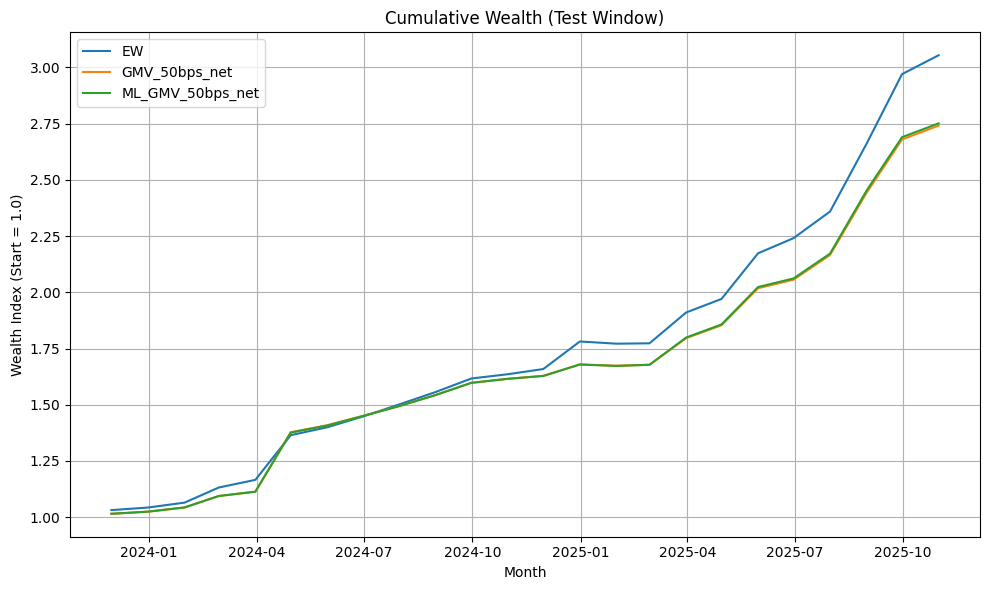

Saved: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\figures\ch4_equity_curves_net_returns.png


In [85]:
# ============================================================
# STEP 21B-1: Cumulative wealth (equity curves)
# ============================================================

cum_wealth = (1.0 + returns_21A).cumprod()

plt.figure(figsize=(10, 6))
for col in cum_wealth.columns:
    plt.plot(cum_wealth.index, cum_wealth[col], label=col)

plt.title("Cumulative Wealth (Test Window)")
plt.xlabel("Month")
plt.ylabel("Wealth Index (Start = 1.0)")
plt.legend()
plt.grid(True)

fig_path = fig_dir / "ch4_equity_curves_net_returns.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved:", fig_path)


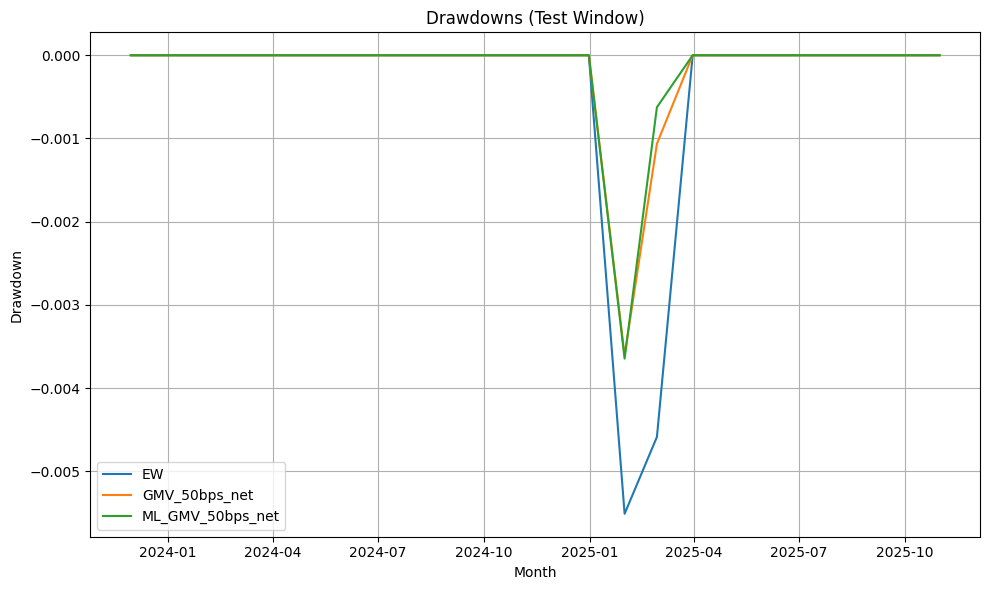

Saved: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\figures\ch4_drawdowns_net_returns.png


In [86]:
# ============================================================
# STEP 21B-2: Drawdowns
# ============================================================

def compute_drawdown(wealth: pd.Series) -> pd.Series:
    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    return dd

drawdowns = pd.DataFrame({col: compute_drawdown(cum_wealth[col]) for col in cum_wealth.columns})

plt.figure(figsize=(10, 6))
for col in drawdowns.columns:
    plt.plot(drawdowns.index, drawdowns[col], label=col)

plt.title("Drawdowns (Test Window)")
plt.xlabel("Month")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)

fig_path = fig_dir / "ch4_drawdowns_net_returns.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved:", fig_path)


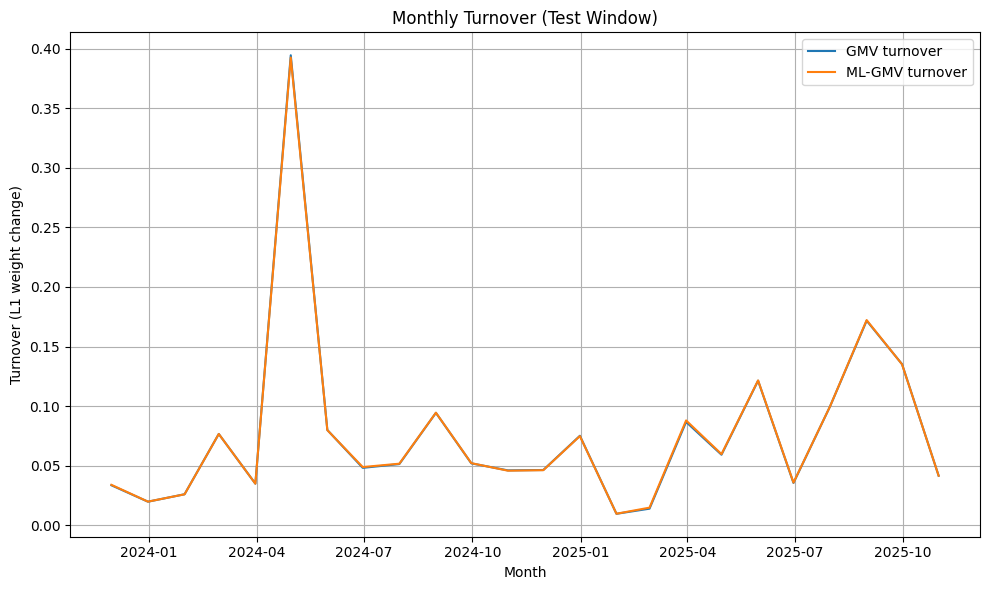

Saved: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\figures\ch4_turnover_comparison.png
Avg turnover — GMV: 0.07732670718835558
Avg turnover — ML-GMV: 0.07742959934577494


In [87]:
# ============================================================
# STEP 21B-3: Turnover series (GMV vs ML-GMV)
# ============================================================

# Safety: turnover should exist from Step 19/20 backtests
if "turnover" not in gmv_bt.columns:
    raise KeyError("gmv_bt is missing 'turnover' column.")
if "turnover" not in ml_bt.columns:
    raise KeyError("ml_bt is missing 'turnover' column.")

turnover_df = pd.DataFrame({
    "GMV_turnover": gmv_bt["turnover"],
    "ML_GMV_turnover": ml_bt["turnover"],
}).dropna()

plt.figure(figsize=(10, 6))
plt.plot(turnover_df.index, turnover_df["GMV_turnover"], label="GMV turnover")
plt.plot(turnover_df.index, turnover_df["ML_GMV_turnover"], label="ML-GMV turnover")

plt.title("Monthly Turnover (Test Window)")
plt.xlabel("Month")
plt.ylabel("Turnover (L1 weight change)")
plt.legend()
plt.grid(True)

fig_path = fig_dir / "ch4_turnover_comparison.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved:", fig_path)

print("Avg turnover — GMV:", float(turnover_df["GMV_turnover"].mean()))
print("Avg turnover — ML-GMV:", float(turnover_df["ML_GMV_turnover"].mean()))


In [88]:
# ============================================================
# STEP 21C: Implementation summary table (Chapter 4)
# ============================================================

# --- Safety checks ---
required = [
    "ew_test_returns",
    "gmv_bt",
    "ml_bt",
    "gmv_metrics",
    "ml_net_metrics_50bps",
    "paths"
]
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Missing prerequisites before Step 21C: {missing}")

# --- EW metrics (computed here for symmetry) ---
ew_metrics = perf_metrics(
    ew_test_returns,
    risk_free_rate_annual=rc.risk_free_rate_annual
)

# --- Average turnover and costs ---
avg_turnover_gmv = float(gmv_bt["turnover"].mean())
avg_turnover_ml  = float(ml_bt["turnover"].mean())

avg_cost_gmv = float(gmv_bt["cost"].mean()) if "cost" in gmv_bt.columns else np.nan
avg_cost_ml  = float(ml_bt["cost"].mean()) if "cost" in ml_bt.columns else np.nan

# --- Build summary table ---
summary_21C = pd.DataFrame({
    "Mean monthly return": [
        ew_metrics["mean_monthly"],
        gmv_metrics["mean_monthly"],
        ml_net_metrics_50bps["mean_monthly"],
    ],
    "Monthly volatility": [
        ew_metrics["vol_monthly"],
        gmv_metrics["vol_monthly"],
        ml_net_metrics_50bps["vol_monthly"],
    ],
    "Annualised return (approx)": [
        ew_metrics["mean_annual_approx"],
        gmv_metrics["mean_annual_approx"],
        ml_net_metrics_50bps["mean_annual_approx"],
    ],
    "Annualised volatility (approx)": [
        ew_metrics["vol_annual_approx"],
        gmv_metrics["vol_annual_approx"],
        ml_net_metrics_50bps["vol_annual_approx"],
    ],
    "Sharpe ratio (annual)": [
        ew_metrics["sharpe_annual"],
        gmv_metrics["sharpe_annual"],
        ml_net_metrics_50bps["sharpe_annual"],
    ],
    "Total return (test window)": [
        ew_metrics["total_return_test"],
        gmv_metrics["total_return_test"],
        ml_net_metrics_50bps["total_return_test"],
    ],
    "Avg monthly turnover": [
        np.nan,               # EW (buy-and-hold)
        avg_turnover_gmv,
        avg_turnover_ml,
    ],
    "Avg monthly cost": [
        np.nan,               # EW (frictionless)
        avg_cost_gmv,
        avg_cost_ml,
    ],
},
index=[
    "EW (frictionless)",
    "GMV (50 bps net)",
    "ML-GMV (50 bps net)",
])

summary_21C


,Mean monthly return,Monthly volatility,Annualised return (approx),Annualised volatility (approx),Sharpe ratio (annual),Total return (test window),Avg monthly turnover,Avg monthly cost
EW (frictionless),0.048440,0.043249,0.581277,0.149819,3.879854,2.053622,NaN,NaN
GMV (50 bps net),0.044063,0.052043,0.528758,0.180284,2.932925,1.740881,0.077327,0.000387
ML-GMV (50 bps net),0.044218,0.051902,0.530614,0.179793,2.951257,1.750980,0.077430,0.000387


In [89]:
# --- Persist for Chapter 4 ---
summary_21C_path = paths.tables_dir / "chapter4_implementation_summary.csv"
summary_21C.to_csv(summary_21C_path)

print("Wrote:", summary_21C_path)


Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\chapter4_implementation_summary.csv


In [90]:
# ============================================================
# TABLE 4.2: GMV vs ML-GMV performance comparison
# ============================================================

# Safety checks
required = [
    "gmv_metrics",
    "ml_net_metrics_50bps",
    "gmv_bt",
    "ml_bt",
    "paths"
]
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Missing prerequisites for Table 4.2: {missing}")

# Average turnover and costs
avg_turnover_gmv = float(gmv_bt["turnover"].mean())
avg_turnover_ml  = float(ml_bt["turnover"].mean())

avg_cost_gmv = float(gmv_bt["cost"].mean()) if "cost" in gmv_bt.columns else np.nan
avg_cost_ml  = float(ml_bt["cost"].mean()) if "cost" in ml_bt.columns else np.nan

# Construct Table 4.2
table_4_2 = pd.DataFrame({
    "GMV (50 bps net)": [
        gmv_metrics["mean_monthly"],
        gmv_metrics["vol_monthly"],
        gmv_metrics["sharpe_annual"],
        gmv_metrics["total_return_test"],
        avg_turnover_gmv,
        avg_cost_gmv,
    ],
    "ML-GMV (50 bps net)": [
        ml_net_metrics_50bps["mean_monthly"],
        ml_net_metrics_50bps["vol_monthly"],
        ml_net_metrics_50bps["sharpe_annual"],
        ml_net_metrics_50bps["total_return_test"],
        avg_turnover_ml,
        avg_cost_ml,
    ],
},
index=[
    "Mean monthly return",
    "Monthly volatility",
    "Annualised Sharpe ratio",
    "Total return (test window)",
    "Average monthly turnover",
    "Average monthly transaction cost",
])

table_4_2


,GMV (50 bps net),ML-GMV (50 bps net)
Mean monthly return,0.044063,0.044218
Monthly volatility,0.052043,0.051902
Annualised Sharpe ratio,2.932925,2.951257
Total return (test window),1.740881,1.750980
Average monthly turnover,0.077327,0.077430
Average monthly transaction cost,0.000387,0.000387


In [91]:
# Save for Chapter 4
table_4_2_path = paths.tables_dir / "table4_2_gmv_vs_ml_comparison.csv"
table_4_2.to_csv(table_4_2_path)

print("Wrote:", table_4_2_path)


Wrote: C:\Users\Christopher\Desktop\MBA_FIN\Thesis\thesis_quant_analysis\zambia-ml-portfolio-optimisation\outputs\tables\table4_2_gmv_vs_ml_comparison.csv


In [92]:
# ============================================================
# STEP 4.5A: Macro data discovery (paths + available files)
# ============================================================

from pathlib import Path
import pandas as pd

# 1) Inspect Paths object for anything macro-related
macro_like = [a for a in dir(paths) if any(k in a.lower() for k in ["macro", "cpi", "inflation", "fx", "exchange", "interest", "policy", "boz", "gdp"])]
print("Potential macro-related Paths attributes:")
for a in macro_like:
    try:
        v = getattr(paths, a)
        print(f"  - {a}: {v}")
    except Exception as e:
        print(f"  - {a}: <error reading attribute> {e}")

# 2) Search common folders under project root for macro files
root = Path(paths.project_root) if hasattr(paths, "project_root") else Path.cwd()
candidate_dirs = [
    root / "data",
    root / "data" / "macro",
    root / "inputs",
    root / "inputs" / "macro",
    root / "raw",
    root / "raw" / "macro",
]

patterns = ["*macro*.csv", "*macro*.xlsx", "*cpi*.csv", "*cpi*.xlsx", "*inflation*.csv", "*inflation*.xlsx",
            "*fx*.csv", "*fx*.xlsx", "*exchange*.csv", "*exchange*.xlsx", "*interest*.csv", "*interest*.xlsx",
            "*boz*.csv", "*boz*.xlsx", "*gdp*.csv", "*gdp*.xlsx"]

found = []
for d in candidate_dirs:
    if d.exists():
        for pat in patterns:
            found.extend(list(d.glob(pat)))

found = sorted(set(found))
print("\nMacro candidate files found:")
for f in found:
    print("  -", f)

if not found:
    print("\nNo macro files found in the common directories. If your macro data is stored elsewhere, tell me the folder name (e.g., 'raw_data') and I will adjust the search cell.")


Potential macro-related Paths attributes:

Macro candidate files found:

No macro files found in the common directories. If your macro data is stored elsewhere, tell me the folder name (e.g., 'raw_data') and I will adjust the search cell.
